# Agent based modelling of a wildfire

Initial Forest


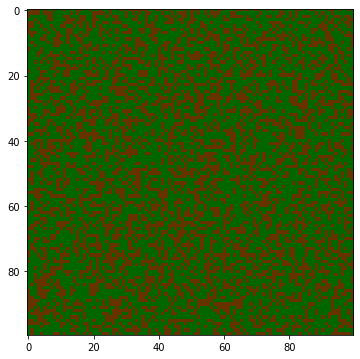

Fire has been set


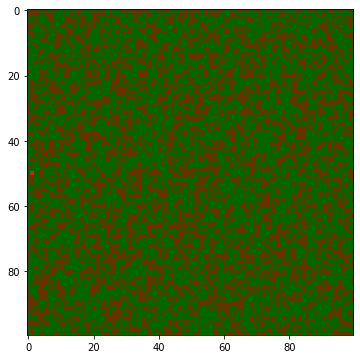

After 200 days


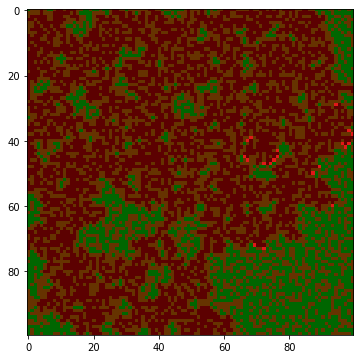

In [111]:
"""Agent based modelling of a wildfire.

@author: Damian Hoedtke
@date: Feb, 28th '22

"""
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass

# constants
STATE_EMPTY = -1
STATE_ALIVE = 0
STATE_BURNING = 1
STATE_BURNED = 2

@dataclass
class Tree:
    state: int # see states
    burning_time: float

        
@dataclass
class Forest:
    trees: np.ndarray
    xsize: int
    ysize: int
    time: float

        
def create_forest(Ni, density):
    trees = np.ndarray((Ni, Ni), dtype=Tree)
    forest = Forest(trees, trees.shape[0], trees.shape[1], time=0)
    # plant trees
    n_trees = int(density * forest.trees.size)
    rng = np.random.default_rng(seed=101)
    floating_indices = rng.choice(forest.trees.size, size=n_trees, replace=False)
    indices = np.column_stack(np.unravel_index(floating_indices, forest.trees.shape))
    for index in indices:
        forest.trees[tuple(index)] = Tree(STATE_ALIVE, burning_time=0)
    return forest

def array_repr(forest: Forest):
    """Returns the array representation of the forest.
    
    -1: no tree
    0: lively tree
    1: burning tree
    2: burned
    """
    array_forest = np.zeros((forest.xsize, forest.ysize), dtype=np.int64)
    for k, tree in np.ndenumerate(forest.trees):
        array_forest[k] = tree.state if tree else STATE_EMPTY
    return array_forest

forest = create_forest(100, 0.6)


def show(forest):
    fig = plt.figure(figsize=(6, 6))
    palette = np.array([[0, 102, 0],
                        [225, 24, 24],
                        [92, 1, 1],
                        [102, 51, 0]])
    # convert tree states to colors
    state = array_repr(forest)
    color_state = np.copy(state)
    color_state[state == STATE_EMPTY] = -1
    color_state[state == STATE_ALIVE] = 0
    color_state[state == STATE_BURNING] = 1
    color_state[state == STATE_BURNED] = 2
    
    plt.imshow(palette[color_state])
    plt.show()

print('Initial Forest')
show(forest)

def ignite(forest, index):
    # seed fire
    forest.trees[index] = Tree(STATE_BURNING, burning_time=0)
    # reset time
    forest.time = 0.
    
def seed_fire(forest):
    # seed fire at the west (left) side
    # find tree with acceptable location
    # for simplicity the tree density
    # is ignored and one fixed burning tree is created
    index = (int(0.5 * forest.trees.shape[0]), 1)
    # seed fire
    ignite(forest, index)
    

seed_fire(forest)
print('Fire has been set')
show(forest)
    
def elapse(forest, dt, dt_burning):
    for _ in range(dt):
        timestep(forest, dt_burning)
    
def timestep(forest, dt_burning):
    is_burning = lambda tree: tree.state == STATE_BURNING
    trees_to_ignite = []
    for k, tree in np.ndenumerate(forest.trees):
        if tree: # None if empty
            if is_burning(tree):
                # a burning tree spreads to each of its neigbours
                i, j = k
                neighbours = [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
                for index in neighbours:
                    x, y = index
                    if (x >= forest.xsize or y >= forest.ysize or
                        x < 0 or y < 0): # index outside
                        continue
                    tree_ = forest.trees[tuple(index)]
                    if tree_:
                        if tree_.state == STATE_ALIVE:
                            trees_to_ignite.append(index)
                
                # increase burning time
                tree.burning_time += 1
                # fire goes out after dt_burning
                if tree.burning_time >= dt_burning: 
                    tree.state = STATE_BURNED

    for index in trees_to_ignite:
        ignite(forest, index)
                
    

days = 200
print(f'After {days} days')
elapse(forest, days, 1)
show(forest)

In [58]:
# Visualizations
